<a href="https://colab.research.google.com/github/vahidseydi/CGN/blob/main/GCN_secondStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading dataset file from Github 

In [1]:
! wget 'https://github.com/vahidseydi/CGN/blob/main/Data/amazon_electronics_computers%20(1).npz?raw=true'

--2021-04-18 08:19:19--  https://github.com/vahidseydi/CGN/blob/main/Data/amazon_electronics_computers%20(1).npz?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/vahidseydi/CGN/raw/main/Data/amazon_electronics_computers%20(1).npz [following]
--2021-04-18 08:19:19--  https://github.com/vahidseydi/CGN/raw/main/Data/amazon_electronics_computers%20(1).npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vahidseydi/CGN/main/Data/amazon_electronics_computers%20(1).npz [following]
--2021-04-18 08:19:19--  https://raw.githubusercontent.com/vahidseydi/CGN/main/Data/amazon_electronics_computers%20(1).npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubu

In [2]:
import numpy as np
npz_data=np.load('/content/amazon_electronics_computers (1).npz?raw=true')
npz_data.files

['adj_data',
 'adj_indices',
 'adj_indptr',
 'adj_shape',
 'attr_data',
 'attr_indices',
 'attr_indptr',
 'attr_shape',
 'labels',
 'class_names']

In [3]:
class_names =npz_data['class_names']
class_names

array(['Desktops', 'Data Storage', 'Laptops', 'Monitors',
       'Computer Components', 'Video Projectors', 'Routers', 'Tablets',
       'Networking Products', 'Webcams'], dtype='<U19')

In [4]:
labels =npz_data['labels']
y=labels.size
#p for calculating percentage for idx_train,val,test
p = lambda x: x*y/100


In [5]:
import numpy as np
import scipy.sparse as sp
import torch
from scipy.sparse import  csr_matrix


def load_data():

 features = sp.csr_matrix((npz_data['attr_data'], npz_data['attr_indices'], npz_data['attr_indptr']),
                                        shape=npz_data['attr_shape'])

 # build graph
 
 adj= sp.csr_matrix(sp.csr_matrix((npz_data['adj_data'], npz_data['adj_indices'], npz_data['adj_indptr']),
                                   shape=npz_data['adj_shape']))
 
 # build symmetric adjacency matrix

 adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
 adj = normalize(adj + sp.eye(adj.shape[0]))
 #اول اعداد 0 و 1 هست بعد از نرمالایز تغییر میکند 

 labels=npz_data['labels']

 idx_train =range(round(p(70)))
 idx_val = range(idx_train[-1],idx_train[-1]+round(p(20)))
 idx_test =range(idx_val[-1],idx_val[-1]+round(p(10)))

 idx_train = torch.LongTensor(idx_train)
 idx_val = torch.LongTensor(idx_val)
 idx_test = torch.LongTensor(idx_test)

 features = torch.FloatTensor(np.array(features.todense()))
 adj = torch.FloatTensor(np.array(adj.todense()))
 labels = torch.LongTensor(labels)


 return adj, features, labels, idx_train, idx_val, idx_test

In [6]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    #sum in every row 
    r_inv = np.power(rowsum, -1).flatten()
    # every sum to the power of -1 
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    #diagonal matrice 
    mx = r_mat_inv.dot(mx)
    return mx

In [7]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)    

In [8]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()


In [9]:
#layers

import math

import torch

from torch.nn.parameter import Parameter

#class parameter ,param haro cache mikone

from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        
        #Sparse matrix multiplication=spmm
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ') '

In [10]:
#models
import torch.nn as nn
import torch.nn.functional as F
#from layers import GraphConvolution


class GCN(nn.Module):
    def __init__(self, nfeat, nhid,nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
   
        self.dropout = dropout
        
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)


Epoch: 0001 loss_train: 3.0410 acc_train: 0.0948 loss_val: 2.7161 acc_val: 0.1509 time: 1.1252s
Epoch: 0002 loss_train: 2.7546 acc_train: 0.1078 loss_val: 2.4103 acc_val: 0.0695 time: 2.2324s
Epoch: 0003 loss_train: 2.4399 acc_train: 0.0780 loss_val: 2.3160 acc_val: 0.3567 time: 3.3344s
Epoch: 0004 loss_train: 2.3345 acc_train: 0.3397 loss_val: 2.1869 acc_val: 0.3607 time: 4.4419s
Epoch: 0005 loss_train: 2.2373 acc_train: 0.3520 loss_val: 2.0743 acc_val: 0.3604 time: 5.5368s
Epoch: 0006 loss_train: 2.1075 acc_train: 0.3599 loss_val: 1.9363 acc_val: 0.3615 time: 6.6471s
Epoch: 0007 loss_train: 1.9825 acc_train: 0.3621 loss_val: 1.8886 acc_val: 0.3684 time: 7.7661s
Epoch: 0008 loss_train: 1.9118 acc_train: 0.3620 loss_val: 1.8681 acc_val: 0.3687 time: 8.8938s
Epoch: 0009 loss_train: 1.8765 acc_train: 0.3636 loss_val: 1.8323 acc_val: 0.3662 time: 10.0057s
Epoch: 0010 loss_train: 1.8598 acc_train: 0.3629 loss_val: 1.8073 acc_val: 0.4356 time: 11.1224s
Epoch: 0011 loss_train: 1.8118 acc_tra

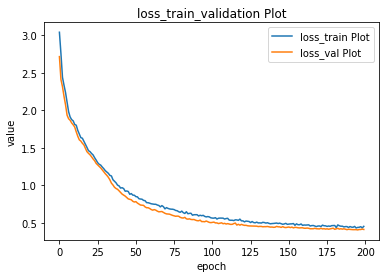

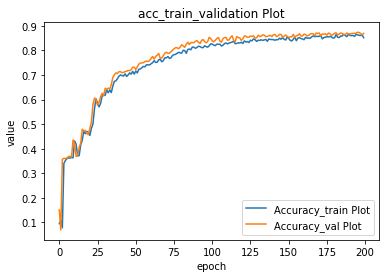

Optimization Finished!
Total time elapsed: 223.4413s
GCN(
  (gc1): GraphConvolution (767 -> 16) 
  (gc2): GraphConvolution (16 -> 10) 
)
Test set results: loss= 0.3994 accuracy= 0.8749


In [12]:
#train

from __future__ import division
from __future__ import print_function
from torchsummary import summary

import time
import argparse
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import torch.nn.functional as F
import torch.optim as optim
#from utils import load_data, accuracy
#from models import GCN

# Training settings

parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')

parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')

#args = parser.parse_args()
#error midad khate bala,khate paein jaigozin shod

args = parser.parse_known_args()[0]

args.cuda = not args.no_cuda and torch.cuda.is_available()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data

adj, features, labels, idx_train, idx_val, idx_test = load_data()

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=10,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)


## to set cuda as your device if possible
##training on  GPU

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    
    ## train:adjust the weights on the neural network
    ## validation:used to minimize overfitting
 
def test():
    ## Turn on evaluation mode which disables dropout.
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

def train(epoch):
  model.train()
  optimizer.zero_grad()
  output = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  acc_train = accuracy(output[idx_train], labels[idx_train])
  # Computing the gradients necessary to adjust the weights
  loss_train.backward()
  # Updating the weights of the neural network
  optimizer.step()
  losses.append(loss_train.item())
  acc.append(acc_train.item())

  if not args.fastmode:
    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    output = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])
  acc_val = accuracy(output[idx_val], labels[idx_val])
  losses_val.append(loss_val.item())
  acc_valid.append(acc_val.item())

  print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

# Train model
t_total = time.time()
losses = []
acc=[]
losses_val = []
acc_valid=[]
t = time.time()
for epoch in range(args.epochs):
    train(epoch)

#plotting loss_train_val:

plt.plot(np.array(losses),label ='loss_train Plot')
plt.plot(np.array(losses_val),label ='loss_val Plot')
plt.title('loss_train_validation Plot')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

#plotting acc_train_val:

plt2.plot(np.array(acc),label ='Accuracy_train Plot')
plt2.plot(np.array(acc_valid),label ='Accuracy_val Plot')
plt2.title('acc_train_validation Plot')
plt2.xlabel('epoch')
plt2.ylabel('value')
plt2.legend()
plt2.show()    

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print(model)
#summary(model,[(13381,767),(13381,13381)])
# Testing
test()


